<a href="https://colab.research.google.com/github/ttogle918/ds-section2-sprint2/blob/main/n223-evaluation-metrics-for-classification/n223a-evaluation-metrics-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [1]:
# !pip install category_encoders

In [2]:
# !pip uninstall pandas_profiling
# !pip install pandas_profiling
# !pip show pandas_profiling

In [3]:
# google 드라이브에 로컬 파일 업로드
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/test.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/train_labels.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/train.csv")
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/submission.csv")

In [5]:
train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'employment_status', 'census_region', 'census_msa',
       'n_adult_r', 'household_children', 'n_people_r', 'employment_industry',
       'employment_occupation', 'hhs_region', 'state'],
      dtype='object')

In [6]:
target = 'vacc_h1n1_f'

from sklearn.model_selection import train_test_split

train = pd.merge(train, train_labels[target], left_index=True, right_index=True)  # train data + labels
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train[target], random_state=2) # divide
train.shape, val.shape, test.shape, submission.shape

((33723, 39), (8431, 39), (28104, 38), (28104, 2))

In [7]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
#     selected_cols = df.select_dtypes(include=['number', 'object'])
#     colnames = selected_cols.columns.tolist()
#     labels = selected_cols.nunique()
    
#     selected_features = labels[labels <= 30].index.tolist()
#     df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    dels = [col for col in df.columns if ('behavioral' in col )]
    df.drop(columns=dels, inplace=True)
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)
train.head(2)

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,vacc_h1n1_f
20365,1.0,1.0,0.0,1.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Not At All Worried,18 - 34 Years,4.0,3,1,1,2.0,1.0,1,"MSA, Not Principle City",4.0,0.0,4.0,2,NEW JERSEY,0
29138,1.0,1.0,1.0,0.0,0.0,1.0,0.0,Somewhat Effective,Somewhat High,Not Very Worried,35 - 44 Years,2.0,3,2,3,2.0,2.0,2,Non-MSA,2.0,2.0,4.0,7,IOWA,1


In [8]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [9]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

백신 접종에 대한 정밀도, 재현율

In [10]:
# positives = tp + fp
# actual = tp + fn

def precision(tp, positives) : # 정밀도
  return tp/positives

def recall(tp, actual) :  # 재현율 = 민감도
  return tp/actual
prec = precision(tp, tp+fp)
rec = recall(tp, tp+fn)
prec, rec

(0.7456773543730065, 0.697112366603892)

재현율에 정밀도의 2배 가중치를 부여한다 -> F_2, Β= 2

정밀도에 재현율의 2배 가중치를 부여한다 -> F_0.5, Β= 0.5 

(1+beta**2)*((precision*recall)/((beta**2*precision)+recall))

In [11]:
def f_beta_value(beta, precision, recall) :
  return (1 + pow(beta, 2)) * precision * recall / ( pow(beta, 2) * precision + recall )

In [12]:
from sklearn.metrics import fbeta_score

f_beta_value(2, prec, rec)
# fbeta_score(, , average='macro', beta=0.5)

0.7063126093178567

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [14]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
def my_make_pipeline(n) :
  pipe = make_pipeline(
      OrdinalEncoder(), 
      SimpleImputer(), 
      RandomForestClassifier(n_estimators=n, random_state=2, n_jobs=-1)
  )
  return pipe

pipe = my_make_pipeline(100)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8235084806072827


In [15]:
# encoder = OrdinalEncoder()

# rf = RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
# rf.fit(X_train, y_train)

Predicted probabilities:
[[0.79 0.21]
 [0.95 0.05]
 [0.97 0.03]
 ...
 [0.94 0.06]
 [0.49 0.51]
 [0.74 0.26]]


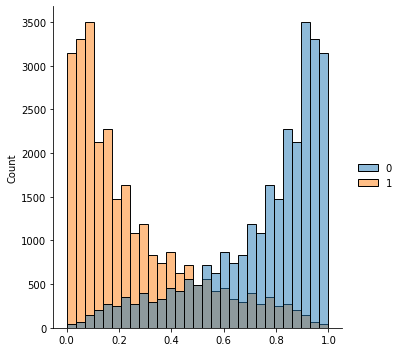

In [17]:
import seaborn as sns
y_pred_proba = pipe.predict_proba(X_test)
print("Predicted probabilities:\n{}".format(pipe.predict_proba(X_test)))
sns.displot(y_pred_proba);

False    23870
True      4234
dtype: int64

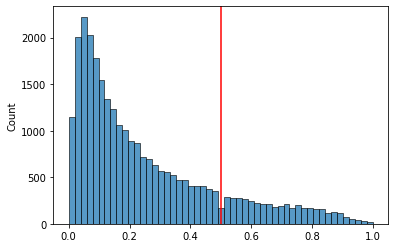

In [18]:
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_test)[:,1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_val, y_pred))

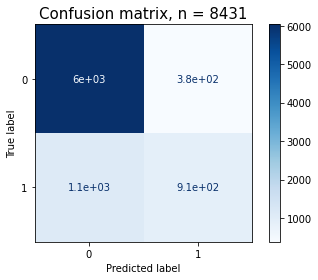

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(객관식) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [20]:
### 이곳에서 과제를 진행해 주세요 ###
for i in [1, 10, 100, 1000] :
  pipe = my_make_pipeline(i)
  print("Predicted probabilities:\n{}".format(pipe.predict_proba(X_test)))
  # pipe = 

ValueError: ignored

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 제출하세요.**

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 